In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
fname ='/content/drive/My Drive/asign-14-LSTM/'
!ls "/content/drive/My Drive/asign-14-LSTM"

vocab_cmn.pkl  word_idx.pkl  x_test.pkl  X_train.pkl  y_test.pkl  y_train.pkl


In [0]:
# Credits: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# LSTM for sequence classification in the IMDB dataset
import numpy
import pickle
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)


### [1] Convert AMZNFFReview data to IMDB format ###

In [0]:
 #%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np

import scipy
from collections import Counter
from itertools import islice
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
import nltk
from nltk import word_tokenize, sent_tokenize

import re
import pickle

from tqdm import tqdm
import os
import time

class asign_14_lstm:

	def __init__(self):		
		self.X_train = []
		self.x_test = []
		self.X_trn = pd.DataFrame()  # temporary
		self.x_tst = pd.DataFrame()  # temporary		
		self.y_train = []
		self.y_test = []
		self.vocab_cmn = []
		self.vocab_all = []
		self.top_wrd_cnt = None
		self.wrd_idx = dict()
		self.X_trn_lst = []

	@property
	def X_train(self):
	    return self._X_train

	@X_train.setter
	def X_train(self,new_X_train):
	    self._X_train = new_X_train        

	@property
	def X_trn(self):
	    return self._X_trn

	@X_trn.setter
	def X_trn(self,new_X_trn):
	    self._X_trn = new_X_trn

	@property
	def X_tst(self):
	    return self._X_tst

	@X_tst.setter
	def X_trn(self,new_X_tst):
	    self._X_tst = new_X_tst
	    	    
	# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
	def partition(self,x):
		if x < 3:
			return 0
		return 1

	def write_data(self,fnme,opdata):

		#fname = 'E:/appliedaicourse/assignments/dblite/kdtree_50k/' + fnme
		fname = 'E:/appliedaiacourse/assignments/asign-14-LSTM/' + fnme
		with open(fname, 'wb') as fp:
			pickle.dump(opdata, fp)

	def decontracted(self,phrase):
		# specific
		phrase = re.sub(r"won't", "will not", phrase)
		phrase = re.sub(r"can\'t", "can not", phrase)

		# general
		phrase = re.sub(r"n\'t", " not", phrase)
		phrase = re.sub(r"\'re", " are", phrase)
		phrase = re.sub(r"\'s", " is", phrase)
		phrase = re.sub(r"\'d", " would", phrase)
		phrase = re.sub(r"\'ll", " will", phrase)
		phrase = re.sub(r"\'t", " not", phrase)
		phrase = re.sub(r"\'ve", " have", phrase)
		phrase = re.sub(r"\'m", " am", phrase)

		return phrase			



	# Combining all the above statements 
	def rw_preproc(self,xdata):

		preprocessed_reviews = []

		# tqdm is for printing the status bar
		
		for sentance in tqdm(xdata.values):
			sentance = re.sub(r"http\S+", "", sentance)
			sentance = BeautifulSoup(sentance, 'lxml').get_text()
			sentance = self.decontracted(sentance)
			sentance = re.sub("\S*\d\S*", "", sentance).strip()
			sentance = re.sub('[^A-Za-z]+', ' ', sentance)
			# https://gist.github.com/sebleier/554280
			sentance = ' '.join(e.lower() for e in sentance.split() )
			preprocessed_reviews.append(sentance.strip())
		return preprocessed_reviews


	def getreviews(self, nrows):
		X_trn = pd.DataFrame()		
		# using SQLite Table to read data.
		filepath = os.path.abspath('E:/appliedaiacourse/assignments/dblite/database.sqlite') 
		assert os.path.exists(filepath), 'the file does not exist'
		con = sqlite3.connect(filepath) 
		#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con)
		if nrows == -1 :
			# fetch all rows
			filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """ , con)			
		else:

			filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT """ + str(nrows), con)

		#changing reviews with score less than 3 to be positive and vice-versa
		actualScore = filtered_data['Score']
		positiveNegative = actualScore.map(self.partition) 
		filtered_data['Score'] = positiveNegative
		#Sorting data according to ProductId in ascending order
		sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')	
		#Deduplication of entries
		final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
		final.shape

		final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

		#Before starting the next phase of preprocessing lets see the number of entries left
		print(final.shape)

		#How many positive and negative reviews are present in our dataset?
		final['Score'].value_counts()

		X_trn, X_tst, self.y_train, self.y_test = train_test_split(final['Text'], final['Score'], stratify= final['Score'],test_size=0.2, random_state=42)
		
		self.X_trn = self.rw_preproc(X_trn)
		self.x_tst  = self.rw_preproc(X_tst)
		
	def crea_vocab(self):
		k =0
		for sent in self.X_trn:
			words =sent.split()
			self.vocab_all += words
			k += 1
			print('crea_vocb fn processing ', k, 'th row')

	def crea_imdb_fmt(self,xdata, xlist):
		k=0
		for sent in xdata:
			words = sent.split()
			tmplst =[]
			for  word  in words:
				if word in self.wrd_idx:
					tmplst.append(self.wrd_idx[word])
				else:
					tmplst.append(0)
			k += 1
			xlist.append(tmplst)
			print('crea_imdb_fmt fn processing ', k, 'th row')
		return xlist
				



if __name__ == "__main__" :
	
	print('Process Starting')

	#instantiate the class
	ls_tm = asign_14_lstm()
	
	#get the reviews from db
	ls_tm.getreviews(50000)	
	#max features
	ls_tm.top_wrd_cnt = 5000

	#create vocabulary
	ls_tm.crea_vocab()

	count= Counter(ls_tm.vocab_all)

	#get most common words
	ls_tm.vocab_cmn = count.most_common(ls_tm.top_wrd_cnt)

	i = 1

	for wrd, frq in ls_tm.vocab_cmn:
		ls_tm.wrd_idx[wrd] = i
		i += 1

	xlist =[]
	ls_tm.X_train = ls_tm.crea_imdb_fmt(ls_tm.X_trn,xlist)

	xlist =[]
	ls_tm.x_test = ls_tm.crea_imdb_fmt(ls_tm.x_tst,xlist)

	print(ls_tm.X_train[1])
	print(type(ls_tm.X_train[1]))
	print(len(ls_tm.X_train[1]))
	print(ls_tm.x_test[1])
	print(type(ls_tm.x_test[1]))
	print(len(ls_tm.x_test[1]))
	
	ls_tm.write_data('vocab_cmn.pkl',ls_tm.vocab_cmn)
	ls_tm.write_data('word_idx.pkl', ls_tm.wrd_idx)
	ls_tm.write_data('X_train.pkl',ls_tm.X_train)
	ls_tm.write_data('x_test.pkl',ls_tm.x_test)
	ls_tm.write_data('y_train.pkl',ls_tm.y_train)
	ls_tm.write_data('y_test.pkl',ls_tm.y_test)

## [1.1] Loading the AMZNFFReview dataset

In [0]:
with open(fname+'X_train.pkl', 'rb') as fp:
    X_train = pickle.load(fp)
    
with open(fname+'x_test.pkl', 'rb') as fp1:
  x_test = pickle.load(fp1)
  
with open(fname+'y_train.pkl', 'rb') as fp2:  
  y_train = pickle.load(fp2)
  
with open(fname+'y_test.pkl', 'rb') as fp3:
  y_test = pickle.load(fp3)


In [7]:
from keras import backend
backend.clear_session()

In [8]:
# truncate and/or pad input sequences
max_review_length = 600
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])



(36856, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

In [0]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_mdl_res(x_val, trn_los, tst_los, tst_scr, tst_acc):
  # Visualize loss history
  plt.figure(figsize=(16,16))
  plt.plot(x_val, trn_los, 'r--')
  plt.plot(x_val, tst_los, 'b-')
  plt.title('Training Vs Test Loss')
  plt.legend(['Training Loss', 'Test Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.show();
  print('Test score:', tst_scr)
  print('Test accuracy:', tst_acc)
  
def plt_mdl_acc(x_val, trn_acc, tst_acc):
  # Visualize loss history
  plt.figure(figsize=(16,16))
  plt.plot(x_val, trn_acc, 'r--')
  plt.plot(x_val, tst_acc, 'b-')
  plt.title('Training Vs Test Accuracy')
  plt.legend(['Training Accuracy', 'Test Accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.show();


### [2] Single Level LSTM ###
**[2.1]No Dropout with kernel_regularization and Batch_Normalization**

In [0]:
import keras
# create the model
embedding_vecor_length = 32
top_words = 5000
no_epoch = 10
batch_size = 64
mdl_1 = Sequential()
optimize = keras.optimizers.Adam()
optimize.learning_rate=0.0000000001
mdl_1.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
#mdl_1.add(LSTM(100)) overfitting -- reducing number of units to 64
mdl_1.add(LSTM(16,kernel_regularizer=l2(0.000001)))   #overfitting -- reducing number of units to 32
mdl_1.add(BatchNormalization())
#mdl_1.add(LSTM(16)) train and test accuracy are the same
mdl_1.add(Dense(1, activation='sigmoid'))
mdl_1.compile(loss='binary_crossentropy', optimizer=optimize, metrics=['accuracy'])
print(mdl_1.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 163,249
Trainable params: 163,217
Non-trainable params: 32
_________________________________________________________________
None


In [0]:
import keras
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logs_base_dir)
history_1 = mdl_1.fit(X_train, y_train, epochs=no_epoch, batch_size=batch_size,verbose=1,validation_data=(x_test,y_test),callbacks=[tensorboard_callback] )
#history_1 = mdl_1.fit(X_train, y_train, nb_epoch=no_epoch, batch_size=batch_size,verbose=1,validation_data=(x_test,y_test) )
#callbacks=[keras.callbacks.TensorBoard(log_dir="logs/final/{}".format(time()), histogram_freq=1, write_graph=True, write_images=True)]

Train on 36856 samples, validate on 9215 samples
Epoch 1/10
36856/36856 [==============================] - 259s 7ms/step - loss: 0.4768 - acc: 0.8280 - val_loss: 0.4459 - val_acc: 0.8345
Epoch 2/10
36856/36856 [==============================] - 259s 7ms/step - loss: 0.4427 - acc: 0.8350 - val_loss: 0.4603 - val_acc: 0.8347
Epoch 3/10
36856/36856 [==============================] - 267s 7ms/step - loss: 0.4429 - acc: 0.8350 - val_loss: 0.4863 - val_acc: 0.8277
Epoch 4/10
36856/36856 [==============================] - 266s 7ms/step - loss: 0.4426 - acc: 0.8351 - val_loss: 0.4471 - val_acc: 0.8349
Epoch 5/10
36856/36856 [==============================] - 267s 7ms/step - loss: 0.4424 - acc: 0.8352 - val_loss: 1.2666 - val_acc: 0.1648
Epoch 6/10
36856/36856 [==============================] - 266s 7ms/step - loss: 0.4424 - acc: 0.8352 - val_loss: 0.4808 - val_acc: 0.8352
Epoch 7/10
36856/36856 [==============================] - 266s 7ms/step - loss: 0.4424 - acc: 0.8352 - val_loss: 0.4625 - v

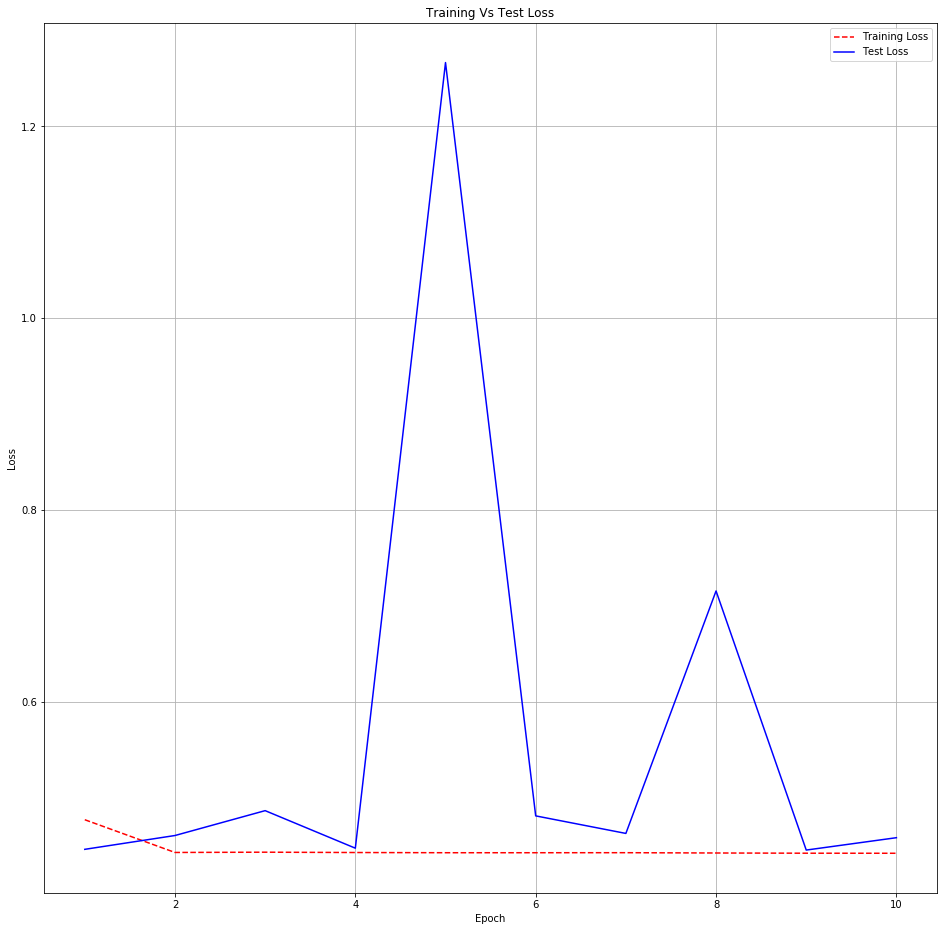

Test score: 0.45805796802658394
Test accuracy: 0.8349430275881866


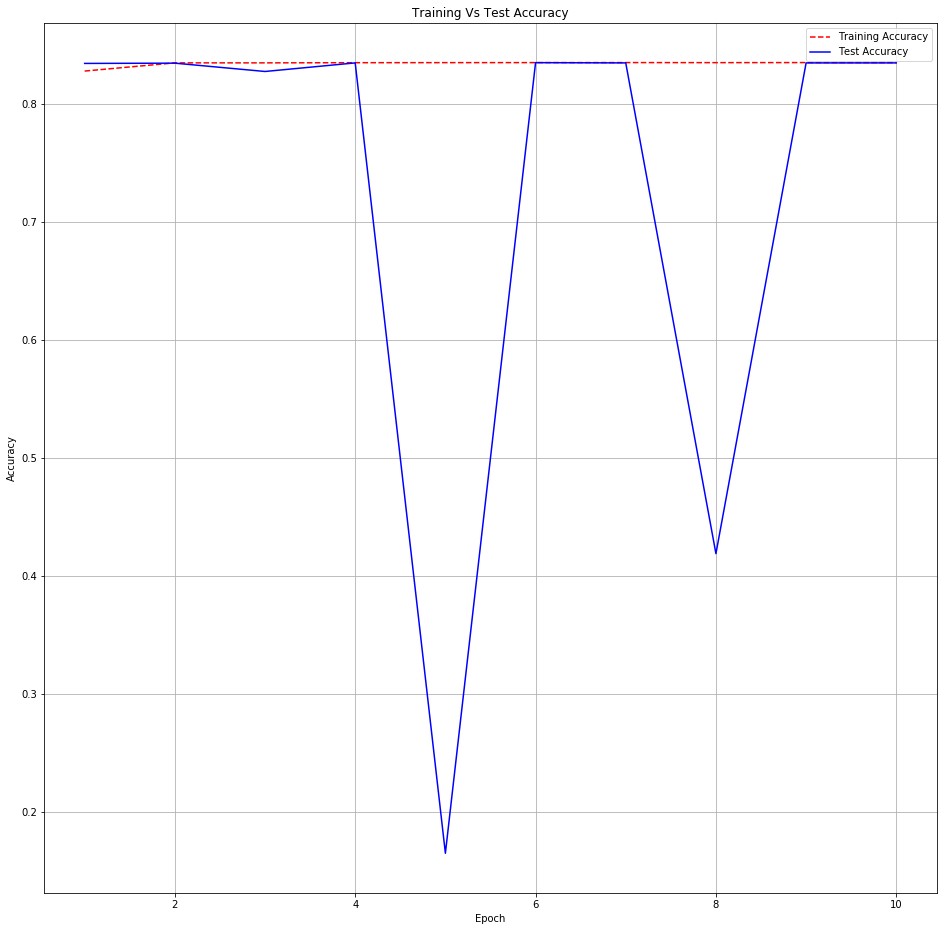

In [0]:
%matplotlib inline
import keras
from matplotlib import pyplot as plt
no_epoch = 10
epoch_count = list(range(1,no_epoch+1))
# Get training and test loss histories
training_loss = history_1.history['loss']
test_loss = history_1.history['val_loss']
# Create count of the number of epochs
score = mdl_1.evaluate(x_test, y_test, verbose=0)
plt_mdl_res(epoch_count, training_loss, test_loss, score[0], score[1])

train_acc = history_1.history['acc']
test_acc = history_1.history['val_acc']
plt_mdl_acc(epoch_count,train_acc,test_acc)

**[2.1.2]More epochs**

In [0]:
import keras
# create the model
embedding_vecor_length = 32
top_words = 5000
no_epoch = 15
batch_size = 64
mdl_1 = Sequential()
optimize = keras.optimizers.Adam()
optimize.learning_rate=0.0000000001
mdl_1.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
#mdl_1.add(LSTM(100)) overfitting -- reducing number of units to 64
mdl_1.add(LSTM(16,kernel_regularizer=l2(0.000001)))   #overfitting -- reducing number of units to 32
mdl_1.add(BatchNormalization())
#mdl_1.add(LSTM(16)) train and test accuracy are the same
mdl_1.add(Dense(1, activation='sigmoid'))
mdl_1.compile(loss='binary_crossentropy', optimizer=optimize, metrics=['accuracy'])
print(mdl_1.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 163,249
Trainable params: 163,217
Non-trainable params: 32
_________________________________________________________________
None


In [0]:
import keras
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logs_base_dir, histogram_freq=1, write_graph=True, write_images=True)
history_1 = mdl_1.fit(X_train, y_train, epochs=no_epoch, batch_size=batch_size,verbose=1,validation_data=(x_test,y_test),callbacks=[tensorboard_callback] )
#history_1 = mdl_1.fit(X_train, y_train, nb_epoch=no_epoch, batch_size=batch_size,verbose=1,validation_data=(x_test,y_test) )
#callbacks=[keras.callbacks.TensorBoard(log_dir="logs/final/{}".format(time()), histogram_freq=1, write_graph=True, write_images=True)]

Train on 36856 samples, validate on 9215 samples


Epoch 1/15
36856/36856 [==============================] - 279s 8ms/step - loss: 0.4770 - acc: 0.8266 - val_loss: 1.6801 - val_acc: 0.1648
Epoch 2/15
36856/36856 [==============================] - 273s 7ms/step - loss: 0.4428 - acc: 0.8348 - val_loss: 0.4461 - val_acc: 0.8349
Epoch 3/15
36856/36856 [==============================] - 274s 7ms/step - loss: 0.4423 - acc: 0.8350 - val_loss: 0.5648 - val_acc: 0.8352
Epoch 4/15
36856/36856 [==============================] - 287s 8ms/step - loss: 0.4423 - acc: 0.8351 - val_loss: 0.8610 - val_acc: 0.8352
Epoch 5/15
36856/36856 [==============================] - 290s 8ms/step - loss: 0.4423 - acc: 0.8351 - val_loss: 0.4466 - val_acc: 0.8348
Epoch 6/15
36856/36856 [==============================] - 288s 8ms/step - loss: 0.4420 - acc: 0.8350 - val_loss: 0.5003 - val_acc: 0.8329
Epoch 7/15
36856/36856 [==============================] - 288s 8ms/step - loss: 0.4419 - acc: 0.8350 - val_loss: 0.4423 -

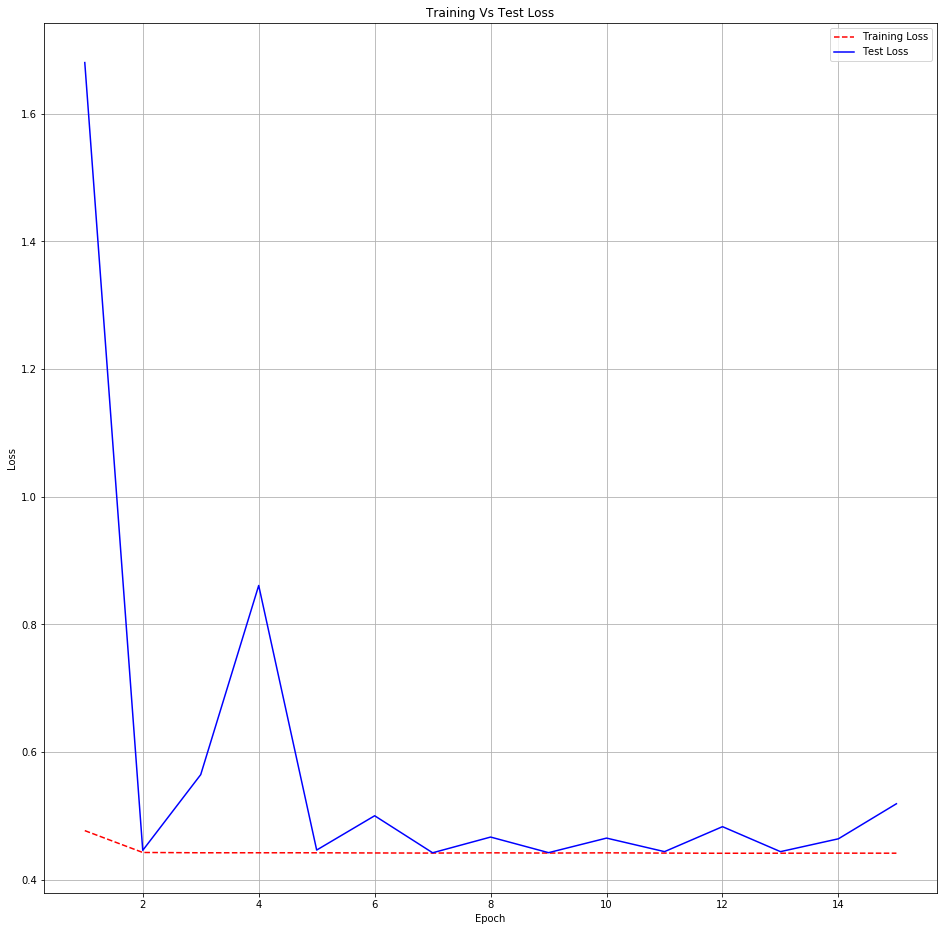

Test score: 0.5191142415974493
Test accuracy: 0.8350515463076658


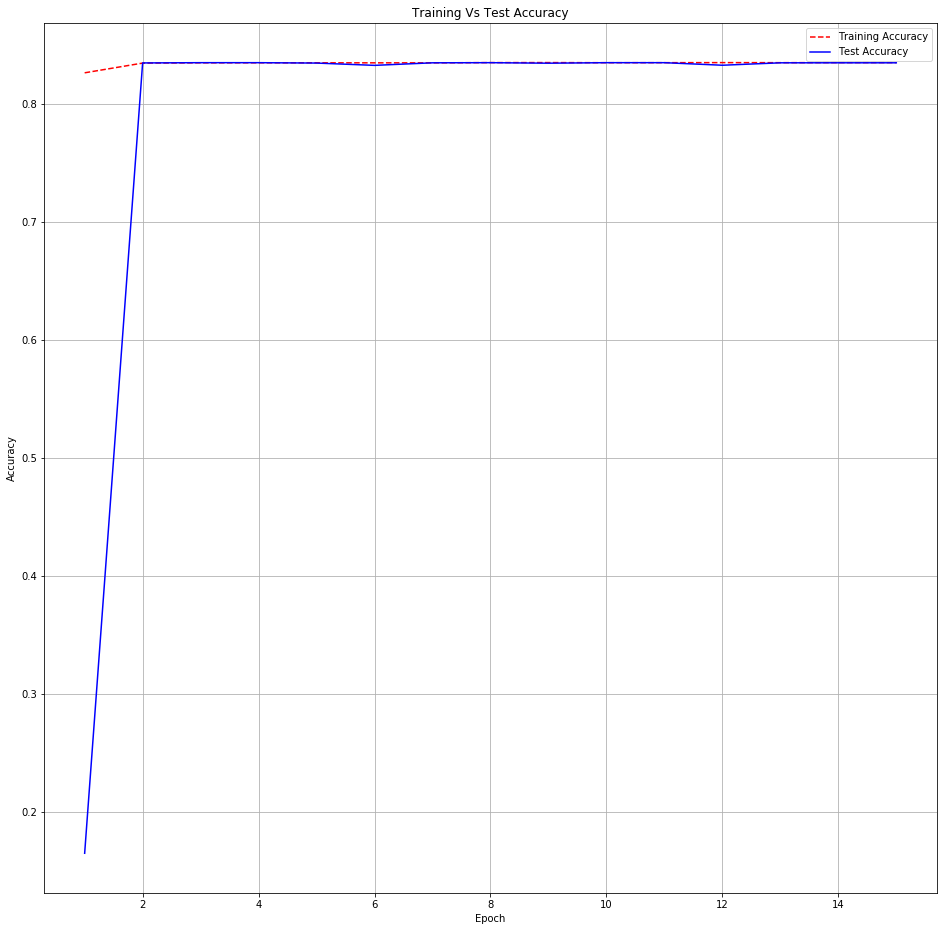

In [0]:
%matplotlib inline
import keras
from matplotlib import pyplot as plt
no_epoch = 15
epoch_count = list(range(1,no_epoch+1))
# Get training and test loss histories
training_loss = history_1.history['loss']
test_loss = history_1.history['val_loss']
# Create count of the number of epochs
score = mdl_1.evaluate(x_test, y_test, verbose=0)
plt_mdl_res(epoch_count, training_loss, test_loss, score[0], score[1])

train_acc = history_1.history['acc']
test_acc = history_1.history['val_acc']
plt_mdl_acc(epoch_count,train_acc,test_acc)

**[2.1.3]More neurons**

In [10]:
import keras
# create the model
embedding_vecor_length = 32
top_words = 5000
no_epoch = 10
batch_size = 64
mdl_1 = Sequential()
optimize = keras.optimizers.Adam()
optimize.learning_rate=0.0000000001
mdl_1.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
#mdl_1.add(LSTM(100)) overfitting -- reducing number of units to 64
mdl_1.add(LSTM(32,kernel_regularizer=l2(0.000001)))   #overfitting -- reducing number of units to 32
mdl_1.add(BatchNormalization())
#mdl_1.add(LSTM(16)) train and test accuracy are the same
mdl_1.add(Dense(1, activation='sigmoid'))
mdl_1.compile(loss='binary_crossentropy', optimizer=optimize, metrics=['accuracy'])
print(mdl_1.summary())
history_1 = mdl_1.fit(X_train, y_train, epochs=no_epoch, batch_size=batch_size,verbose=1,validation_data=(x_test,y_test) )






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 168,513
Trainable params: 168,449
Non-trainable params: 64
_________________________________________________________________
None



Train on 36856 samples, validate on 9215 samples
Epoch 1/10





36856/36856 [==============================] - 236s 6ms/step - loss: 0.307

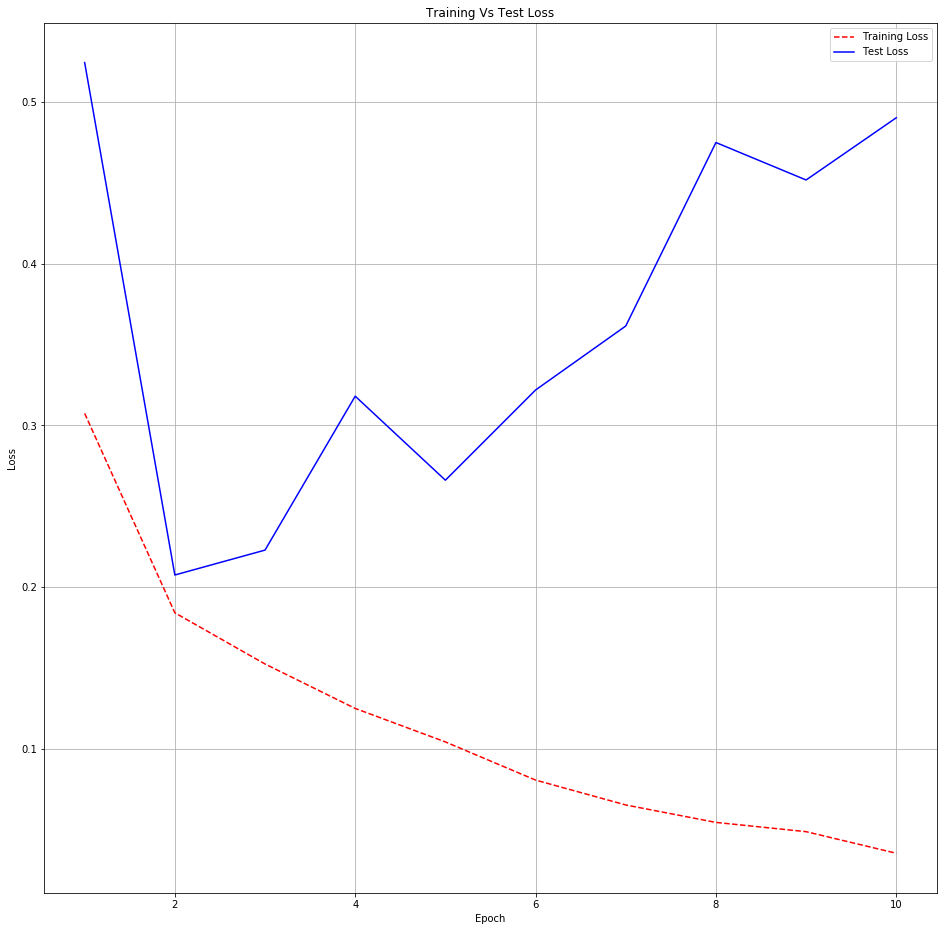

Test score: 0.49025379213233133
Test accuracy: 0.9018990776038208


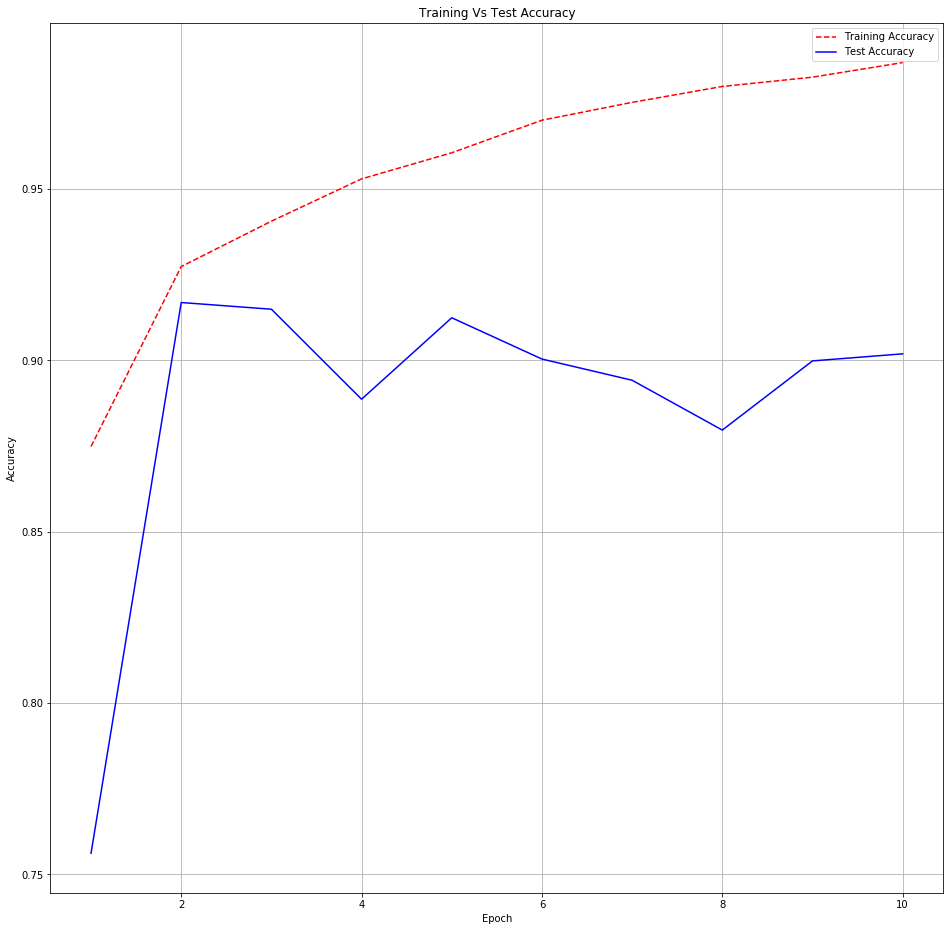

In [12]:
%matplotlib inline
import keras
from matplotlib import pyplot as plt
no_epoch = 10
epoch_count = list(range(1,no_epoch+1))
# Get training and test loss histories
training_loss = history_1.history['loss']
test_loss = history_1.history['val_loss']
# Create count of the number of epochs
score = mdl_1.evaluate(x_test, y_test, verbose=0)
plt_mdl_res(epoch_count, training_loss, test_loss, score[0], score[1])

train_acc = history_1.history['acc']
test_acc = history_1.history['val_acc']
plt_mdl_acc(epoch_count,train_acc,test_acc)

**[2.1.4]More neurons with dropout**

In [13]:
import keras
# create the model
embedding_vecor_length = 32
top_words = 5000
no_epoch = 10
batch_size = 64
mdl_1 = Sequential()
optimize = keras.optimizers.Adam()
optimize.learning_rate=0.0000000001
mdl_1.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
#mdl_1.add(LSTM(100)) overfitting -- reducing number of units to 64
mdl_1.add(LSTM(32,kernel_regularizer=l2(0.000001)))   #overfitting -- reducing number of units to 32
mdl_1.add(Dropout(rate=0.2))
mdl_1.add(BatchNormalization())
#mdl_1.add(LSTM(16)) train and test accuracy are the same
mdl_1.add(Dense(1, activation='sigmoid'))
mdl_1.compile(loss='binary_crossentropy', optimizer=optimize, metrics=['accuracy'])
print(mdl_1.summary())
history_1 = mdl_1.fit(X_train, y_train, epochs=no_epoch, batch_size=batch_size,verbose=1,validation_data=(x_test,y_test) )


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 168,513
Trainable params: 168,449
Non-trainable params: 64
________________________________________________________________

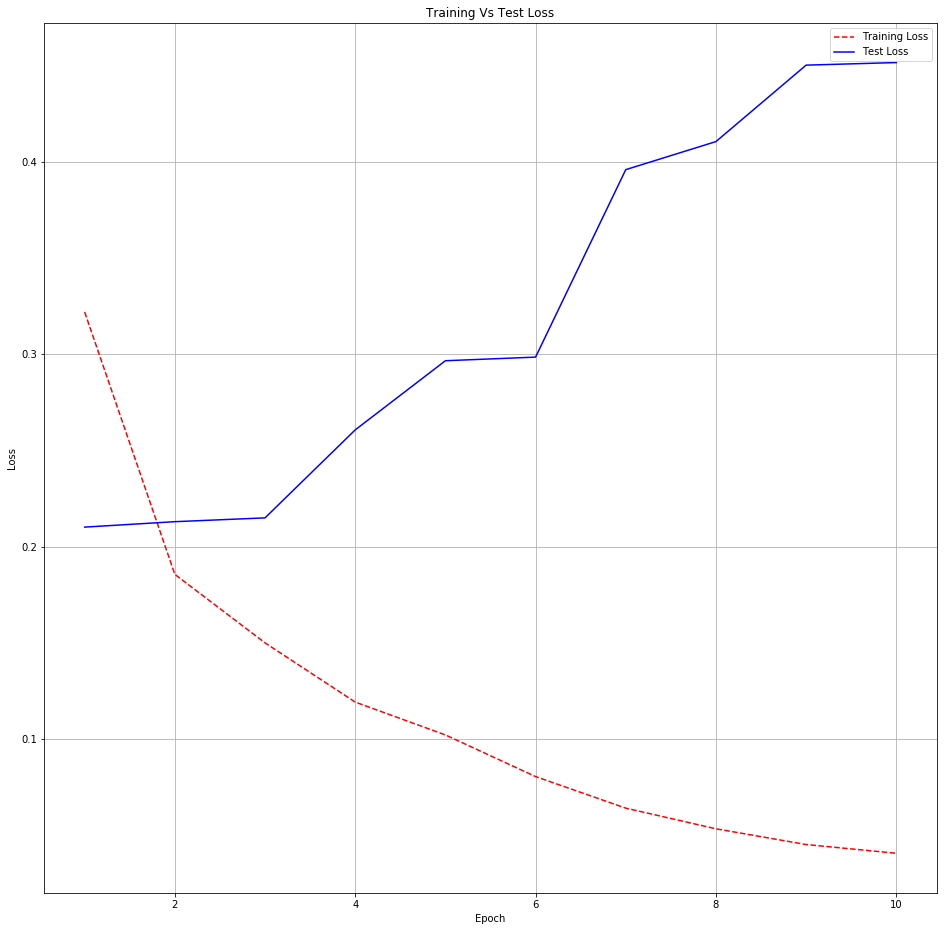

Test score: 0.45151769720984103
Test accuracy: 0.9020075963233


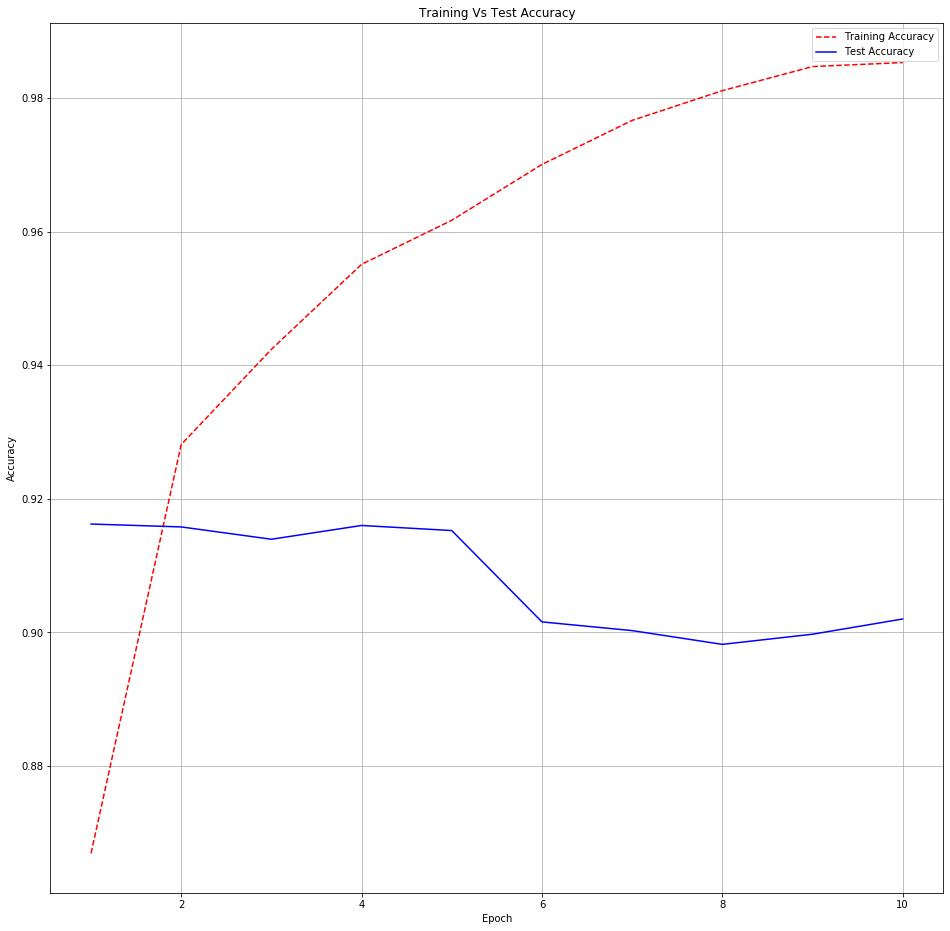

In [14]:
%matplotlib inline
import keras
from matplotlib import pyplot as plt
no_epoch = 10
epoch_count = list(range(1,no_epoch+1))
# Get training and test loss histories
training_loss = history_1.history['loss']
test_loss = history_1.history['val_loss']
# Create count of the number of epochs
score = mdl_1.evaluate(x_test, y_test, verbose=0)
plt_mdl_res(epoch_count, training_loss, test_loss, score[0], score[1])

train_acc = history_1.history['acc']
test_acc = history_1.history['val_acc']
plt_mdl_acc(epoch_count,train_acc,test_acc)

**[2.1.5]Simple**

In [0]:
# create the model
embedding_vecor_length = 32
top_words = 5000
no_epoch = 10
batch_size = 64
mdl_1 = Sequential()
mdl_1.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
mdl_1.add(LSTM(64)) 
mdl_1.add(Dense(1, activation='sigmoid'))
mdl_1.compile(loss='binary_crossentropy', optimizer=optimize, metrics=['accuracy'])
print(mdl_1.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 600, 32)           160032    
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 184,929
Trainable params: 184,929
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
import keras
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logs_base_dir)
history_1 = mdl_1.fit(X_train, y_train, epochs=no_epoch, batch_size=batch_size,verbose=1,validation_data=(x_test,y_test),callbacks=[tensorboard_callback] )
#history_1 = mdl_1.fit(X_train, y_train, nb_epoch=no_epoch, batch_size=batch_size,verbose=1,validation_data=(x_test,y_test) )

Train on 36856 samples, validate on 9215 samples
Epoch 1/10
36856/36856 [==============================] - 373s 10ms/step - loss: 0.3025 - acc: 0.8792 - val_loss: 0.2909 - val_acc: 0.8753
Epoch 2/10
36856/36856 [==============================] - 372s 10ms/step - loss: 0.1948 - acc: 0.9248 - val_loss: 0.2108 - val_acc: 0.9184
Epoch 3/10
36856/36856 [==============================] - 369s 10ms/step - loss: 0.1620 - acc: 0.9390 - val_loss: 0.2036 - val_acc: 0.9220
Epoch 4/10
36856/36856 [==============================] - 371s 10ms/step - loss: 0.1410 - acc: 0.9465 - val_loss: 0.2169 - val_acc: 0.9150
Epoch 5/10
36856/36856 [==============================] - 370s 10ms/step - loss: 0.1199 - acc: 0.9563 - val_loss: 0.2121 - val_acc: 0.9238
Epoch 6/10
36856/36856 [==============================] - 373s 10ms/step - loss: 0.1031 - acc: 0.9621 - val_loss: 0.2172 - val_acc: 0.9252
Epoch 7/10
36856/36856 [==============================] - 373s 10ms/step - loss: 0.0905 - acc: 0.9676 - val_loss: 0.2

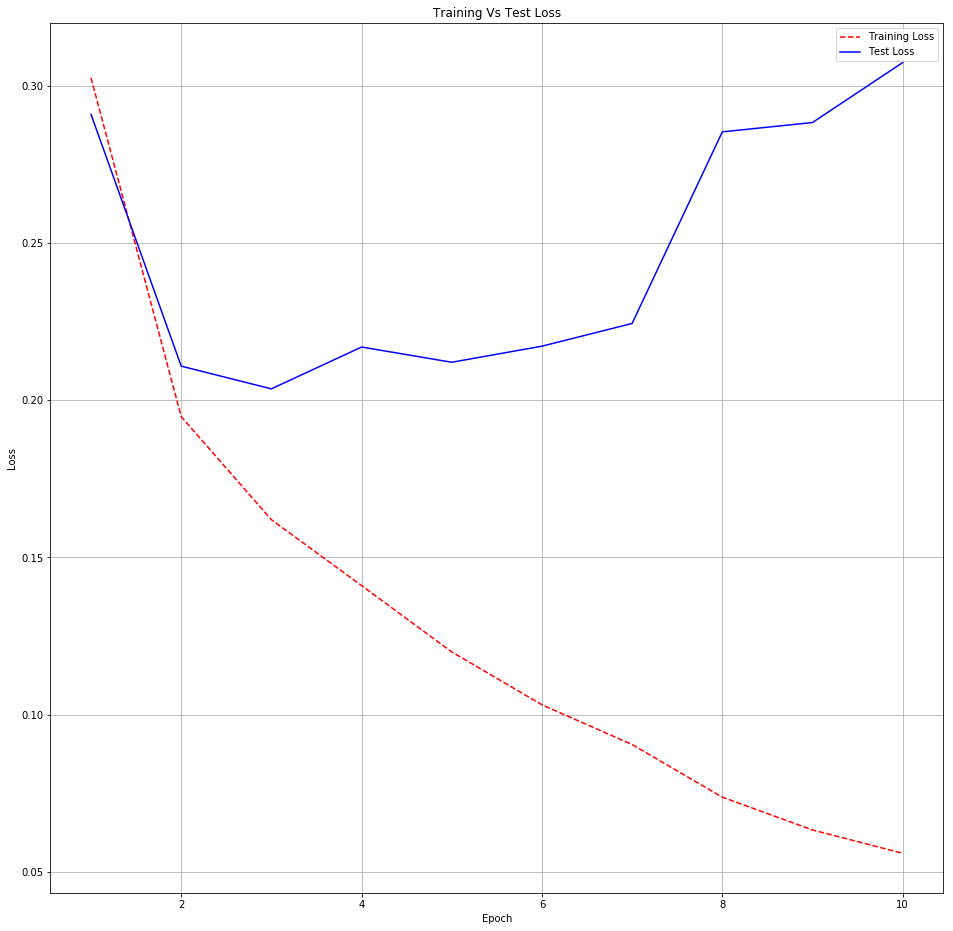

Test score: 0.335425318197847
Test accuracy: 0.9180683668062083


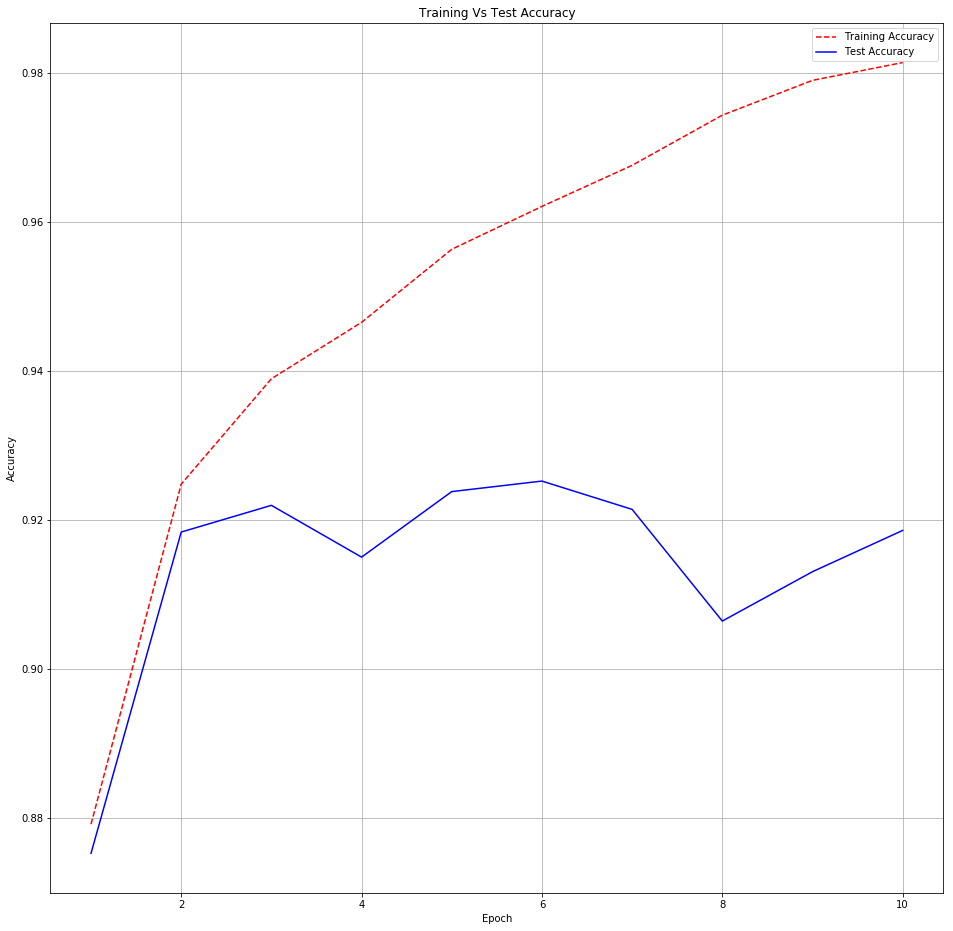

In [0]:
%matplotlib inline
import keras
from matplotlib import pyplot as plt
no_epoch = 10
epoch_count = list(range(1,no_epoch+1))
# Get training and test loss histories
training_loss = history_1.history['loss']
test_loss = history_1.history['val_loss']
# Create count of the number of epochs
score = mdl_1.evaluate(x_test, y_test, verbose=0)
plt_mdl_res(epoch_count, training_loss, test_loss, score[0], score[1])

train_acc = history_1.history['acc']
test_acc = history_1.history['val_acc']
plt_mdl_acc(epoch_count,train_acc,test_acc)

## [2.2] Single Layer LSTM 
** With Regularization and Batch Normalization and No Dropout**

In [0]:
from keras.regularizers import l2
# create the model
embedding_vecor_length = 32
top_words = 5000
no_epoch = 15
batch_size = 64
mdl_21 = Sequential()
mdl_21.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
mdl_21.add(LSTM(100,kernel_regularizer=l2(0.000001)))
mdl_21.add(BatchNormalization())
mdl_21.add(Dense(1, activation='sigmoid'))
mdl_21.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(mdl_21.summary())
history_21 = mdl_21.fit(X_train, y_train, nb_epoch=no_epoch, batch_size=batch_size,verbose=1,validation_data=(x_test,y_test) )      
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               53200     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 213,733
Trainable params: 213,533
Non-trainable params: 200
_________________________________________________________________
None


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 36856 samples, validate on 9215 samples
Epoch 1/15
36856/36856 [==============================] - 574s 16ms/step - loss: 0.2919 - acc: 0.8796 - val_loss: 2.1543 - val_acc: 0.8352
Epoch 2/15
36856/36856 [==============================] - 550s 15ms/step - loss: 0.1951 - acc: 0.9228 - val_loss: 0.2645 - val_acc: 0.9060
Epoch 3/15
36856/36856 [==============================] - 549s 15ms/step - loss: 0.1613 - acc: 0.9359 - val_loss: 0.2786 - val_acc: 0.9046
Epoch 4/15
36856/36856 [==============================] - 549s 15ms/step - loss: 0.1347 - acc: 0.9467 - val_loss: 3.4764 - val_acc: 0.2875
Epoch 5/15
36856/36856 [==============================] - 549s 15ms/step - loss: 0.1205 - acc: 0.9529 - val_loss: 0.3649 - val_acc: 0.8742
Epoch 6/15
36856/36856 [==============================] - 550s 15ms/step - loss: 0.0958 - acc: 0.9640 - val_loss: 0.3189 - val_acc: 0.8964
Epoch 7/15
36856/36856 [==============================] - 559s 15ms/step - loss: 0.0791 - acc: 0.9699 - val_loss: 0.3

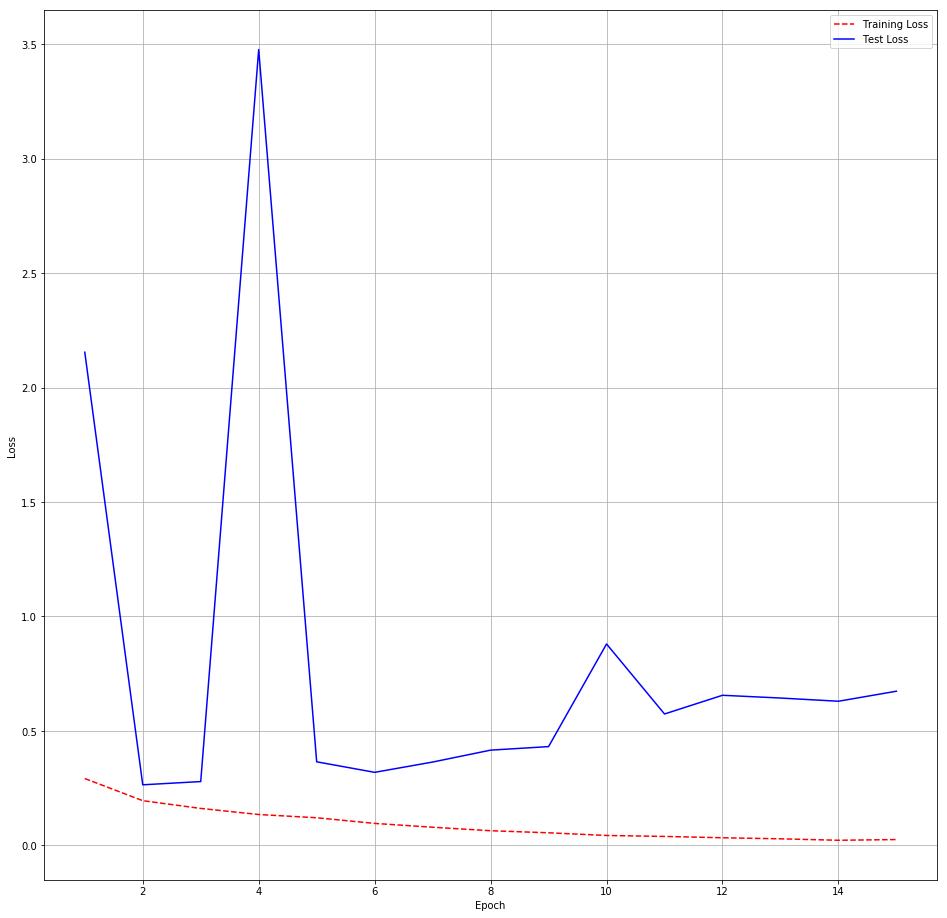

Test score: 0.6733268639977316
Test accuracy: 0.8832338577563906


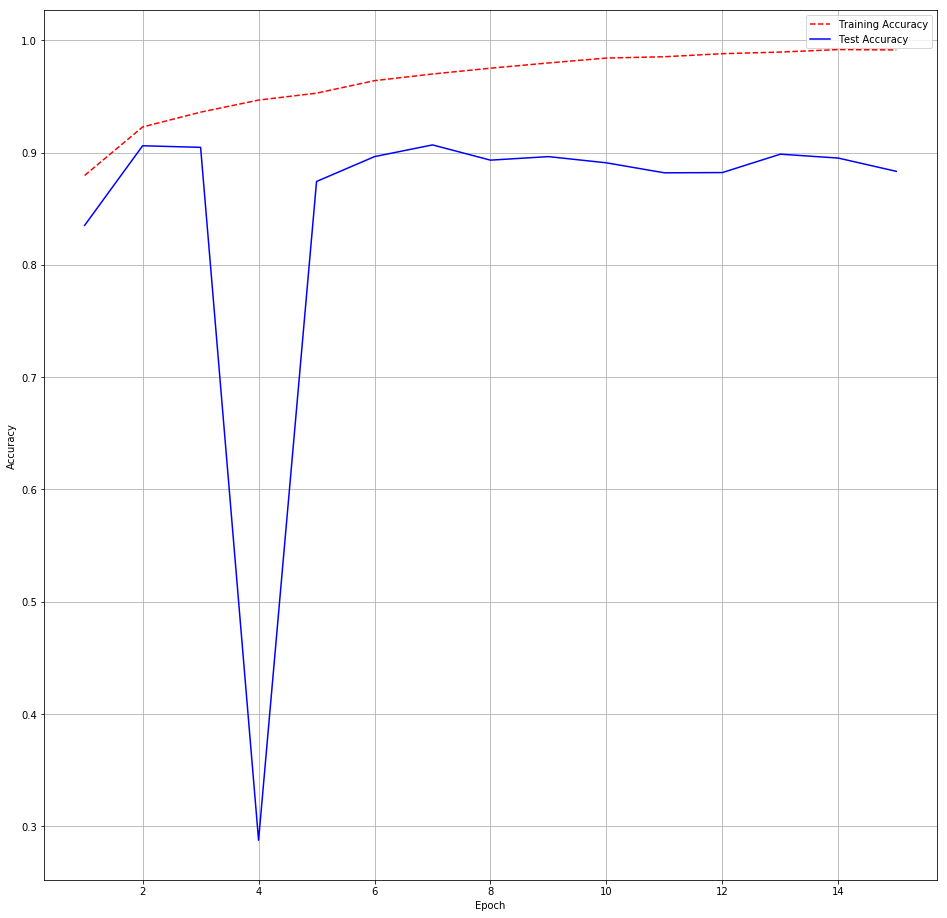

In [0]:
%matplotlib inline
import keras
from matplotlib import pyplot as plt

epoch_count = list(range(1,no_epoch+1))

# Get training and test loss histories
training_loss = history_21.history['loss']
test_loss = history_21.history['val_loss']

# Create count of the number of epochs
score = mdl_21.evaluate(x_test, y_test, verbose=0)
plt_mdl_res(epoch_count, training_loss, test_loss, score[0], score[1])

# Get training and test loss histories
training_aucrcy = history_21.history['acc']
test_aucrcy = history_21.history['val_acc']
plt_mdl_acc(epoch_count, training_aucrcy, test_aucrcy)

###[3]Multi Layered LSTM ###
**[3.1] No Dropout and Batch normalization **

In [0]:
# create the model
embedding_vecor_length = 32
top_words = 5000
no_epoch = 10
batch_size = 64
mdl_3 = Sequential()
mdl_3.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
mdl_3.add(LSTM(100,return_sequences=True))
mdl_3.add(LSTM(64,return_sequences=False))
mdl_3.add(Dense(1, activation='sigmoid'))
mdl_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(mdl_3.summary())
history_3 = mdl_3.fit(X_train, y_train, nb_epoch=no_epoch, batch_size=batch_size,verbose=1,validation_data=(x_test,y_test) )      
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_5 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 255,537
Trainable params: 255,537
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if sys.path[0] == '':


Train on 36856 samples, validate on 9215 samples
Epoch 1/10
36856/36856 [==============================] - 1028s 28ms/step - loss: 0.2936 - acc: 0.8840 - val_loss: 0.2206 - val_acc: 0.9105
Epoch 2/10
36856/36856 [==============================] - 1000s 27ms/step - loss: 0.2036 - acc: 0.9179 - val_loss: 0.2313 - val_acc: 0.9161
Epoch 3/10
36856/36856 [==============================] - 1031s 28ms/step - loss: 0.1673 - acc: 0.9371 - val_loss: 0.2133 - val_acc: 0.9203
Epoch 4/10
36856/36856 [==============================] - 1031s 28ms/step - loss: 0.1502 - acc: 0.9442 - val_loss: 0.2021 - val_acc: 0.9214
Epoch 5/10
36856/36856 [==============================] - 1028s 28ms/step - loss: 0.1331 - acc: 0.9508 - val_loss: 0.2079 - val_acc: 0.9219
Epoch 6/10
36856/36856 [==============================] - 1032s 28ms/step - loss: 0.1144 - acc: 0.9592 - val_loss: 0.2238 - val_acc: 0.9170
Epoch 7/10
36856/36856 [==============================] - 1033s 28ms/step - loss: 0.1023 - acc: 0.9635 - val_lo

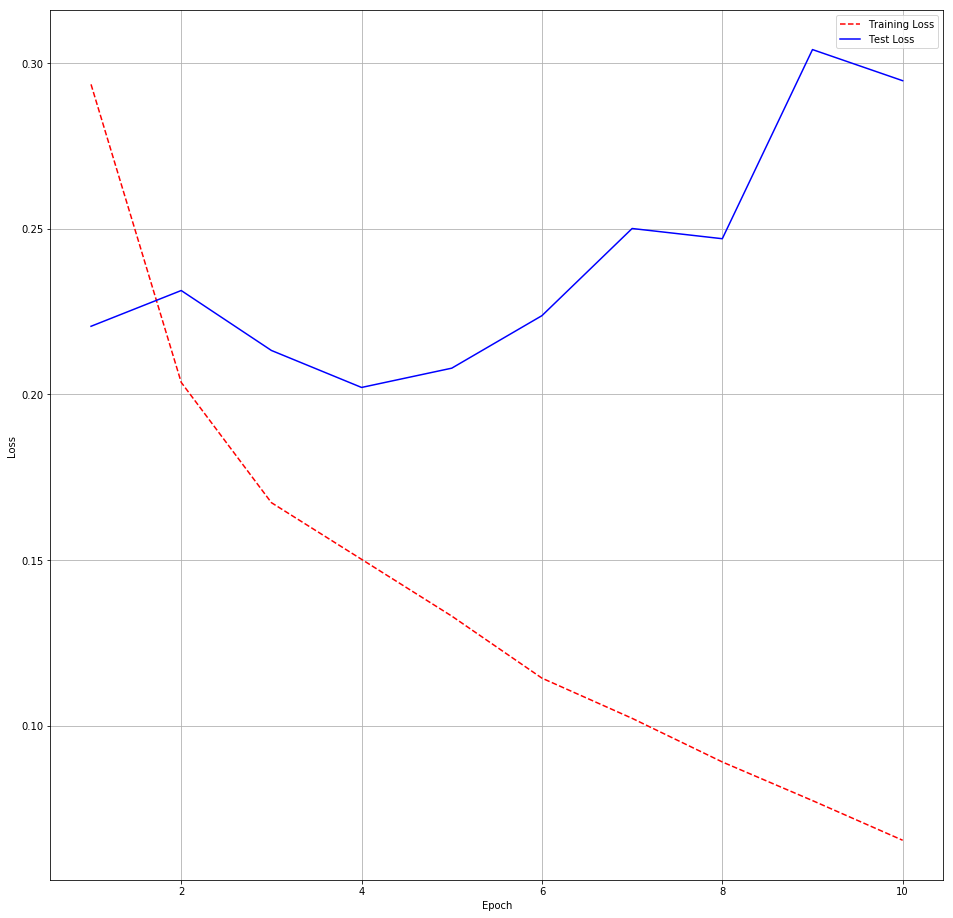

Test score: 0.29465569111069323
Test accuracy: 0.9139446553625106


In [0]:
%matplotlib inline
import keras
from matplotlib import pyplot as plt

epoch_count = list(range(1,no_epoch+1))

# Get training and test loss histories
training_loss = history_3.history['loss']
test_loss = history_3.history['val_loss']

# Create count of the number of epochs
score = mdl_3.evaluate(x_test, y_test, verbose=0)
plt_mdl_res(epoch_count, training_loss, test_loss, score[0], score[1])

### [3.2] Multi Layered LSTM ###
** With Dropout rate = 0.2, Batch normalization and L2 regularization**

In [16]:
# create the model
embedding_vecor_length = 32
top_words = 5000
no_epoch = 20
batch_size = 64
mdl_6 = Sequential()
mdl_6.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
mdl_6.add(LSTM(100,return_sequences=True,kernel_regularizer=l2(0.000001)))
mdl_6.add(Dropout(rate=(0.2)))
mdl_6.add(LSTM(64,return_sequences=True,kernel_regularizer=l2(0.000001)))
mdl_6.add(BatchNormalization())
mdl_6.add(LSTM(32,return_sequences=False,kernel_regularizer=l2(0.000001)))
mdl_6.add(Dropout(rate=(0.2)))
mdl_6.add(BatchNormalization())
mdl_6.add(Dense(1, activation='sigmoid'))
mdl_6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(mdl_6.summary())
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logs_base_dir)
history_6 = mdl_6.fit(X_train, y_train, epochs=no_epoch, batch_size=batch_size,verbose=1,validation_data=(x_test,y_test) )    
%matplotlib inline
import keras
from matplotlib import pyplot as plt

epoch_count = list(range(1,no_epoch+1))

# Get training and test loss histories
training_loss = history_6.history['loss']
test_loss = history_6.history['val_loss']

# Create count of the number of epochs
score = mdl_6.evaluate(x_test, y_test, verbose=0)
plt_mdl_res(epoch_count, training_loss, test_loss, score[0], score[1])

# Get training and test loss histories
training_aucrcy = history_6.history['acc']
test_aucrcy = history_6.history['val_acc']
plt_mdl_acc(epoch_count, training_aucrcy, test_aucrcy)
#history_6 = mdl_6.fit(X_train, y_train, epochs=no_epoch, batch_size=batch_size,verbose=1,validation_data=(x_test,y_test),callbacks=[tensorboard_callback] )      
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_6 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 600, 100)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 600, 64)           42240     
_________________________________________________________________
batch_normalization_5 (Batch (None, 600, 64)           256       
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)               

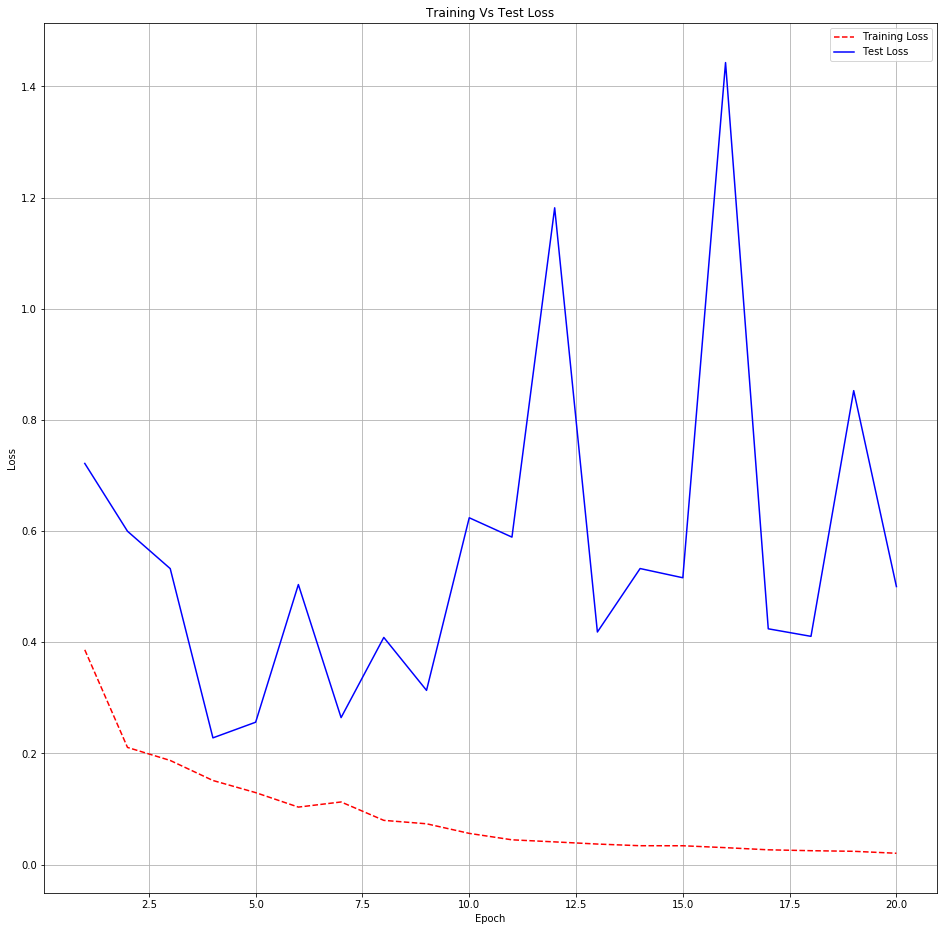

Test score: 0.5001427056665046
Test accuracy: 0.9081931633271411


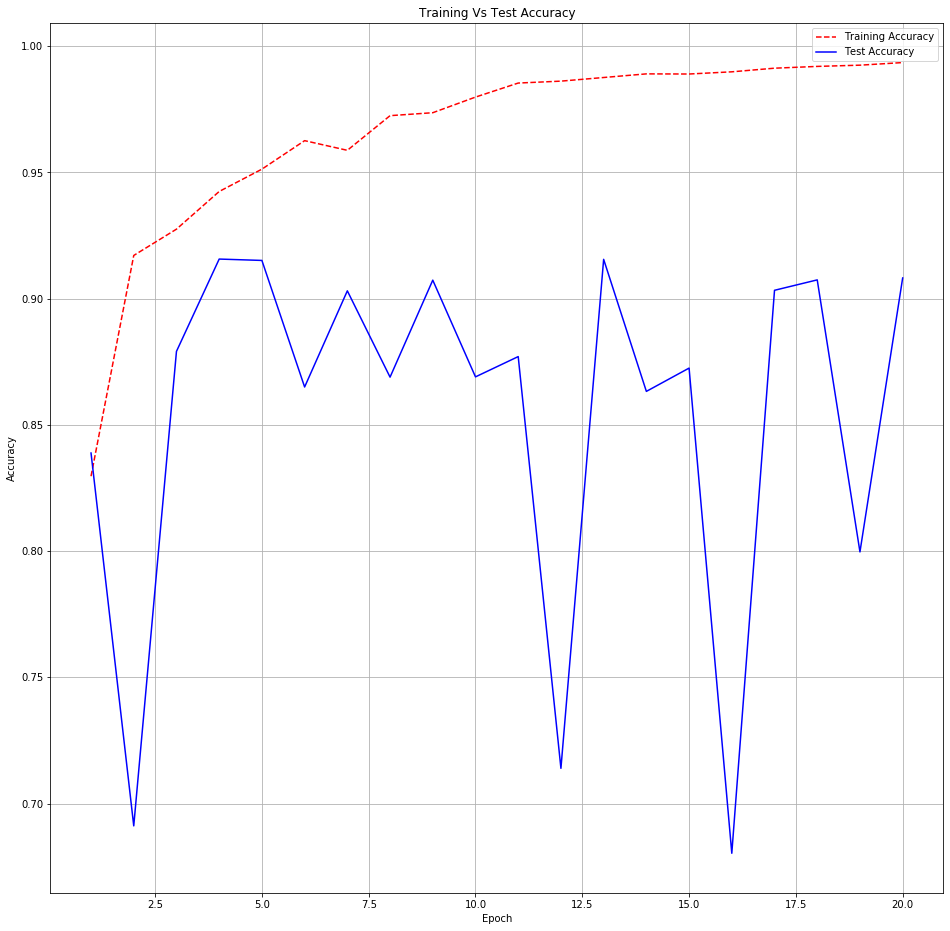

In [17]:
%matplotlib inline
import keras
from matplotlib import pyplot as plt

epoch_count = list(range(1,no_epoch+1))

# Get training and test loss histories
training_loss = history_6.history['loss']
test_loss = history_6.history['val_loss']

# Create count of the number of epochs
score = mdl_6.evaluate(x_test, y_test, verbose=0)
plt_mdl_res(epoch_count, training_loss, test_loss, score[0], score[1])

# Get training and test loss histories
training_aucrcy = history_6.history['acc']
test_aucrcy = history_6.history['val_acc']
plt_mdl_acc(epoch_count, training_aucrcy, test_aucrcy)

#  [4] Conclusion

In [24]:
import tabulate
res_tab =[['Layer','Dimesnion \nOne','Epochs','Regularization \nl2','Batch \nNormalization','Train \nLoss','Test \nLoss','Test \nAccuracy','Refer \nSection'],
         [1,16,15,0.000001,'Yes',0.4417,0.51914,0.835,'2.1.2'],
         [1,100,15,0.000001,'Yes',0.0253,0.6733,0.8832,2.2]]
print(tabulate.tabulate(res_tab,tablefmt='fancy_grid'))

╒═══════╤════════════╤════════╤═════════════════╤═══════════════╤════════╤═════════╤══════════╤═════════╕
│ Layer │ Dimesnion  │ Epochs │ Regularization  │ Batch         │ Train  │ Test    │ Test     │ Refer   │
│       │ One        │        │ l2              │ Normalization │ Loss   │ Loss    │ Accuracy │ Section │
├───────┼────────────┼────────┼─────────────────┼───────────────┼────────┼─────────┼──────────┼─────────┤
│ 1     │ 16         │ 15     │ 1e-06           │ Yes           │ 0.4417 │ 0.51914 │ 0.835    │ 2.1.2   │
├───────┼────────────┼────────┼─────────────────┼───────────────┼────────┼─────────┼──────────┼─────────┤
│ 1     │ 100        │ 15     │ 1e-06           │ Yes           │ 0.0253 │ 0.6733  │ 0.8832   │ 2.2     │
╘═══════╧════════════╧════════╧═════════════════╧═══════════════╧════════╧═════════╧══════════╧═════════╛


In [1]:
import tabulate
res_tab2 =[['Layer','Dimesnion \nOne','Dimension \nTwo','Epochs','Batch \nNormalization','Train \nLoss','Test \nLoss','Test \nAccuracy','Refer \nSection'],
         [1,100,64,10,'No',0.0655,0.2947,0.9139,'3.1']]
print(tabulate.tabulate(res_tab2,tablefmt='fancy_grid'))

╒═══════╤════════════╤════════════╤════════╤═══════════════╤════════╤════════╤══════════╤═════════╕
│ Layer │ Dimesnion  │ Dimension  │ Epochs │ Batch         │ Train  │ Test   │ Test     │ Refer   │
│       │ One        │ Two        │        │ Normalization │ Loss   │ Loss   │ Accuracy │ Section │
├───────┼────────────┼────────────┼────────┼───────────────┼────────┼────────┼──────────┼─────────┤
│ 1     │ 100        │ 64         │ 10     │ No            │ 0.0655 │ 0.2947 │ 0.9139   │ 3.1     │
╘═══════╧════════════╧════════════╧════════╧═══════════════╧════════╧════════╧══════════╧═════════╛


In [26]:
import tabulate
res_tab3 =[['Layer','Dimesnion \nOne','Dimension \nTwo','Dimension \nThree','Epochs','Regularization \nl2','Drop-out \nRate','Batch \nNormalization','Train \nLoss','Test \nLoss','Test \nAccuracy','Refer \nSection'],
         [1,100,64,32,20,0.000001,0.2,'Yes',0.0368,0.4183,0.9081,'3.2']]
print(tabulate.tabulate(res_tab3,tablefmt='fancy_grid'))

╒═══════╤════════════╤════════════╤════════════╤════════╤═════════════════╤═══════════╤═══════════════╤════════╤════════╤══════════╤═════════╕
│ Layer │ Dimesnion  │ Dimension  │ Dimension  │ Epochs │ Regularization  │ Drop-out  │ Batch         │ Train  │ Test   │ Test     │ Refer   │
│       │ One        │ Two        │ Three      │        │ l2              │ Rate      │ Normalization │ Loss   │ Loss   │ Accuracy │ Section │
├───────┼────────────┼────────────┼────────────┼────────┼─────────────────┼───────────┼───────────────┼────────┼────────┼──────────┼─────────┤
│ 1     │ 100        │ 64         │ 32         │ 20     │ 1e-06           │ 0.2       │ Yes           │ 0.0368 │ 0.4183 │ 0.9081   │ 3.2     │
╘═══════╧════════════╧════════════╧════════════╧════════╧═════════════════╧═══════════╧═══════════════╧════════╧════════╧══════════╧═════════╛


In all the above models graphs, it can be observed that the test loss is not increasing after decreasing . This shows that the models are not overfitting the data.